# Applying corrections to columnar data

Here we will show how to use the lookup_tools package in fnal-column-analysis-tools (FCAT).
It is able to read in a variety of correction files as lookup tables.
We also cover here the CMS-specific JET-MET tools that are provided with FCAT.

**Testing Data Generators:**

In [1]:
from coffea.util import awkward
from coffea.util import numpy as np
import uproot_methods


def dummy_jagged_eta_pt():
    np.random.seed(42)
    counts = np.random.exponential(2, size=50).astype(int)
    entries = np.sum(counts)
    test_eta = np.random.uniform(-3., 3., size=entries)
    test_pt = np.random.exponential(10., size=entries)+np.random.exponential(10, size=entries)
    return (counts, test_eta, test_pt)

def dummy_four_momenta():
    np.random.seed(12345)
    nrows = 1000
    counts = np.minimum(np.random.exponential(0.5, size=nrows).astype(int), 20)
    
    px = np.random.normal(loc=20.0,scale=5.0,size=np.sum(counts))
    py = np.random.normal(loc=20.0,scale=5.0,size=np.sum(counts))
    pz = np.random.normal(loc=0, scale=55, size=np.sum(counts))
    m_pi = np.full_like(px,fill_value=0.135)
    energy = np.sqrt(px*px + py*py + pz*pz + m_pi*m_pi)
    return (counts,px,py,pz,energy)

def dummy_events():
    counts, px, py, pz, energy = dummy_four_momenta()
    thep4 = np.stack((px,py,pz,energy)).T

    class obj(object):
        def __init__(self):
            self.p4 = thep4
            self.px = px
            self.py = py
            self.pz = pz
            self.en = energy
            self.pt = np.hypot(px,py)
            self.phi = np.arctan2(py,px)
            self.eta = np.arctanh(pz/np.sqrt(px*px + py*py + pz*pz))
            self.mass = np.sqrt(np.abs(energy*energy - (px*px + py*py + pz*pz)))
            self.blah = energy*px
            self.count = counts
    
    class events(object):
        def __init__(self):
            self.thing = obj()
    
    return events()

def gen_reco_TLV():
    gen_pt = awkward.JaggedArray.fromiter([[10.0, 20.0, 30.0], [], [40.0, 50.0]])
    reco_pt = awkward.JaggedArray.fromiter([[20.2, 10.1, 30.3, 50.5], [50.5], [60]])

    gen_eta = awkward.JaggedArray.fromiter([[-3.0, -2.0, 2.0], [], [-1.0, 1.0]])
    reco_eta = awkward.JaggedArray.fromiter([[-2.2, -3.3, 2.2, 0.0], [0.0], [1.1]])

    gen_phi = awkward.JaggedArray.fromiter([[-1.5, 0.0, 1.5], [], [0.78, -0.78]])
    reco_phi = awkward.JaggedArray.fromiter([[ 0.1, -1.4, 1.4, 0.78], [0.78], [-0.77]])

    gen = uproot_methods.TLorentzVectorArray.from_ptetaphim(gen_pt, gen_eta, gen_phi, 0.2)
    reco = uproot_methods.TLorentzVectorArray.from_ptetaphim(reco_pt, reco_eta, reco_phi, 0.2)

    return (gen, reco)

In [2]:
from coffea.lookup_tools import extractor

## Opening a root file and using it as a lookup table

In [3]:
ext = extractor()
ext.add_weight_sets(["testSF2d scalefactors_Tight_Electron ../tests/samples/testSF2d.histo.root"])
ext.finalize()

evaluator = ext.make_evaluator()

print(dir(evaluator))
print()
print(evaluator['testSF2d'])
print()
print(type(evaluator['testSF2d']))
print()

counts, test_eta, test_pt = dummy_jagged_eta_pt()

# test flat eval
test_out = evaluator["testSF2d"](test_eta, test_pt)

# test structured eval
test_eta_jagged = awkward.JaggedArray.fromcounts(counts, test_eta)
test_pt_jagged = awkward.JaggedArray.fromcounts(counts, test_pt)
test_out_jagged = evaluator["testSF2d"](test_eta_jagged, test_pt_jagged)

print('JAGGED SHAPE COMPARISON')
print('eta      :',test_eta_jagged.counts)
print('pt     :',test_pt_jagged.counts)
print('scaling :',test_out_jagged.counts)

print('output scaling :',test_out_jagged)

['testSF2d']

2 dimensional histogram with axes:
	1: [-2.5   -2.    -1.566 -1.444 -0.8    0.     0.8    1.444  1.566  2.
  2.5  ]
	2: [ 10.  20.  35.  50.  90. 150. 500.]


<class 'coffea.lookup_tools.dense_lookup.dense_lookup'>

JAGGED SHAPE COMPARISON
eta      : [0 6 2 1 0 0 0 4 1 2 0 7 3 0 0 0 0 1 1 0 1 0 0 0 1 3 0 1 1 0 1 0 0 5 6 3 0
 0 2 1 0 1 0 4 0 2 0 1 1 0]
pt     : [0 6 2 1 0 0 0 4 1 2 0 7 3 0 0 0 0 1 1 0 1 0 0 0 1 3 0 1 1 0 1 0 0 5 6 3 0
 0 2 1 0 1 0 4 0 2 0 1 1 0]
scaling : [0 6 2 1 0 0 0 4 1 2 0 7 3 0 0 0 0 1 1 0 1 0 0 0 1 3 0 1 1 0 1 0 0 5 6 3 0
 0 2 1 0 1 0 4 0 2 0 1 1 0]
output scaling : [[] [0.9078014 0.8274854 0.8633218 0.8633218 0.97981155 0.79701495] [0.88245934 0.82857144] ... [1.007752] [0.80655736] []]


## Plotting with weights

In [4]:
from coffea import hist

weights_axis = hist.Cat("wgtname", "With/Without Weights")
eta_axis = hist.Bin("eta", r"$\eta", 20, -2.5, 2.5)
pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 20, 10, 30)

eta_hist = hist.Hist("Counts", weights_axis, eta_axis)
pt_hist = hist.Hist("Counts", weights_axis, pt_axis)

eta_hist.fill(wgtname='weights',eta=test_eta_jagged.flatten(),weight=test_out_jagged.flatten())
eta_hist.fill(wgtname='noweights',eta=test_eta_jagged.flatten())

pt_hist.fill(wgtname='weights',pt=test_pt_jagged.flatten(),weight=test_out_jagged.flatten())
pt_hist.fill(wgtname='noweights',pt=test_pt_jagged.flatten())

In [5]:
fig, ax, _ = hist.plot1d(eta_hist, overlay='wgtname')


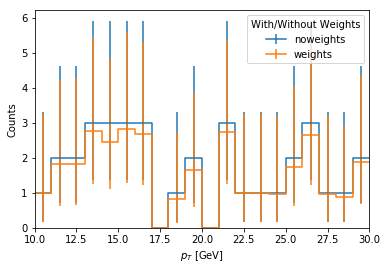

In [6]:
fig, ax, _ = hist.plot1d(pt_hist, overlay='wgtname')


## Importing B-tagging Scale Factors

In [7]:
%%bash
head -5 ../tests/samples/testBTagSF.btag.csv

CSVv2;OperatingPoint, measurementType, sysType, jetFlavor, etaMin, etaMax, ptMin, ptMax, discrMin, discrMax, formula 
0, mujets, central, 1, -2.4, 2.4, 20, 1000, 0, 1, "0.884016*((1.+(0.0331508*x))/(1.+(0.0285096*x)))" 
0, mujets, central, 0, -2.4, 2.4, 20, 1000, 0, 1, "0.884016*((1.+(0.0331508*x))/(1.+(0.0285096*x)))" 
0, mujets, down, 1, -2.4, 2.4, 20, 30, 0, 1, "(0.884016*((1.+(0.0331508*x))/(1.+(0.0285096*x))))-0.063606932759284973" 
0, mujets, down, 1, -2.4, 2.4, 30, 50, 0, 1, "(0.884016*((1.+(0.0331508*x))/(1.+(0.0285096*x))))-0.034989029169082642" 


In [8]:
ext = extractor()
ext.add_weight_sets(["testBTag * ../tests/samples/testBTagSF.btag.csv"])
ext.finalize()

evaluator = ext.make_evaluator()

print(dir(evaluator))
print()
print(evaluator['testBTagCSVv2_1_comb_up_0'])
print()
print(type(evaluator['testBTagCSVv2_1_comb_up_0']))
print()

counts, test_eta, test_pt = dummy_jagged_eta_pt()
# discriminant used for reshaping, zero otherwise
test_discr = np.zeros_like(test_eta)

sf_out = evaluator['testBTagCSVv2_1_comb_up_0'](test_eta, test_pt, test_discr)
print(sf_out)

['testBTagCSVv2_0_comb_central_0', 'testBTagCSVv2_0_comb_central_1', 'testBTagCSVv2_0_comb_down_0', 'testBTagCSVv2_0_comb_down_1', 'testBTagCSVv2_0_comb_up_0', 'testBTagCSVv2_0_comb_up_1', 'testBTagCSVv2_0_incl_central_2', 'testBTagCSVv2_0_incl_down_2', 'testBTagCSVv2_0_incl_down_correlated_2', 'testBTagCSVv2_0_incl_down_uncorrelated_2', 'testBTagCSVv2_0_incl_up_2', 'testBTagCSVv2_0_incl_up_correlated_2', 'testBTagCSVv2_0_incl_up_uncorrelated_2', 'testBTagCSVv2_0_mujets_central_0', 'testBTagCSVv2_0_mujets_central_1', 'testBTagCSVv2_0_mujets_down_0', 'testBTagCSVv2_0_mujets_down_1', 'testBTagCSVv2_0_mujets_up_0', 'testBTagCSVv2_0_mujets_up_1', 'testBTagCSVv2_1_comb_central_0', 'testBTagCSVv2_1_comb_central_1', 'testBTagCSVv2_1_comb_down_0', 'testBTagCSVv2_1_comb_down_1', 'testBTagCSVv2_1_comb_up_0', 'testBTagCSVv2_1_comb_up_1', 'testBTagCSVv2_1_incl_central_2', 'testBTagCSVv2_1_incl_down_2', 'testBTagCSVv2_1_incl_down_correlated_2', 'testBTagCSVv2_1_incl_down_uncorrelated_2', 'testBTagC

## Importing JSON-encoded histograms

In [9]:
%%bash
head -10 ../tests/samples/EIDISO_WH_out.histo.json

{
	"EIDISO_WH" : {
		"eta_pt_ratio" : {
			"eta:[ 0.00, 0.80]":{
				"pt:[25.00,27.00]":{
					"value":0.903,
					"error":0.051
				},
				"pt:[27.00,30.00]":{
					"value":0.921,


In [10]:
ext = extractor()
ext.add_weight_sets(["* * ../tests/samples/EIDISO_WH_out.histo.json"])
ext.finalize()
    
evaluator = ext.make_evaluator()

print(dir(evaluator))
print()
print(evaluator['EIDISO_WH/eta_pt_ratio_value'])
print()
print(type(evaluator['EIDISO_WH/eta_pt_ratio_value']))
print()

counts, test_eta, test_pt = dummy_jagged_eta_pt()
    
sf_out = evaluator['EIDISO_WH/eta_pt_ratio_value'](test_eta, test_pt)
sf_err_out = evaluator['EIDISO_WH/eta_pt_ratio_error'](test_eta, test_pt)
print(sf_out)
print(sf_err_out)

['EIDISO_WH/eta_pt_ratio_error', 'EIDISO_WH/eta_pt_ratio_value']

2 dimensional histogram with axes:
	1: [-2.5  -2.17 -1.8  -1.57 -1.44 -0.8   0.    0.8   1.44  1.57  1.8   2.17
  2.5 ]
	2: [ 25.  27.  30.  32.  35.  40.  50. 200.]


<class 'coffea.lookup_tools.dense_lookup.dense_lookup'>

[0.771 0.83  0.709 0.709 0.935 0.709 0.788 0.771 0.828 0.904 0.862 0.851
 0.791 0.851 0.851 0.903 0.771 0.793 0.774 0.709 0.83  0.771 0.828 0.791
 0.886 0.886 0.83  0.791 0.889 0.788 0.709 0.903 0.851 0.788 0.851 0.851
 0.867 0.867 0.748 0.862 0.788 0.867 0.    0.903 0.83  0.889 0.903 0.862
 0.788 0.788 0.788 0.867 0.893 0.903 0.709 0.    0.862 0.    0.836 0.788
 0.851 0.771]
[0.029 0.035 0.186 0.186 0.009 0.186 0.186 0.027 0.024 0.008 0.051 0.078
 0.027 0.078 0.078 0.051 0.027 0.061 0.036 0.186 0.035 0.027 0.024 0.027
 0.04  0.04  0.035 0.029 0.027 0.186 0.186 0.051 0.078 0.186 0.078 0.078
 0.078 0.078 0.104 0.051 0.186 0.078 0.    0.051 0.035 0.021 0.051 0.051
 0.186 0.186 0.186 0.078 0.029 0.051 0

## Import Jet Energy Scales and Uncertainties

In [11]:
%%bash
head -5 ../tests/samples/Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi.jec.txt

{2 JetEta JetPt 1 JetPt max(0.0001,[0]+((x-[1])*([2]+((x-[1])*([3]+((x-[1])*[4])))))) Correction L2Relative}
  -5.191  -4.889     0.001   8.95328     7           8   8.9532766      2.638647259      7.816547526   -0.08418211224   -0.04894120539    0.03974185455
  -5.191  -4.889   8.95328   10.4135     7   8.9532766   10.413492      2.538089424      8.953276588   -0.04139022814    0.03931172893   -0.02027504013
  -5.191  -4.889   10.4135   12.1083     7   10.413492   12.108301      2.498345769        10.413492   -0.05627613174   -0.01124129111    0.00462608126
  -5.191  -4.889   12.1083   14.3796     7   12.108301   14.379634      2.393199605      12.10830116   -0.05451625473 -0.0004401913391   0.001090215218


In [12]:
ext = extractor()
ext.add_weight_sets([
    "* * ../tests/samples/Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi.jec.txt",
    "* * ../tests/samples/Fall17_17Nov2017_V32_MC_Uncertainty_AK4PFPuppi.junc.txt",
])
ext.finalize()

evaluator = ext.make_evaluator()

print(dir(evaluator))
print()
print(evaluator['Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi'])
print()
print(evaluator['Fall17_17Nov2017_V32_MC_Uncertainty_AK4PFPuppi'])
print()
print(type(evaluator['Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi']))
print()
print(type(evaluator['Fall17_17Nov2017_V32_MC_Uncertainty_AK4PFPuppi']))
print()

counts, test_eta, test_pt = dummy_jagged_eta_pt()
    
jec_out = evaluator['Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi'](test_eta,test_pt)

print(jec_out)

junc_out = evaluator['Fall17_17Nov2017_V32_MC_Uncertainty_AK4PFPuppi'](test_eta,test_pt)

print(junc_out)

['Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi', 'Fall17_17Nov2017_V32_MC_Uncertainty_AK4PFPuppi']

binned dims: ['JetEta', 'JetPt']
eval vars  : ['JetPt']
parameters : ['p0', 'p1', 'p2', 'p3', 'p4']
formula    : max(0.0001,p0+((JetPt-p1)*(p2+((JetPt-p1)*(p3+((JetPt-p1)*p4))))))
signature  : (JetEta,JetPt)


binned dims   : ['JetEta']
eval vars     : ['JetPt']
signature     : (JetEta,JetPt)


<class 'coffea.lookup_tools.jme_standard_function.jme_standard_function'>

<class 'coffea.lookup_tools.jec_uncertainty_lookup.jec_uncertainty_lookup'>

[1.45057193e+00 1.25585204e+00 1.64232333e+00 1.44857384e+00
 1.10674860e+00 5.51830446e+01 1.43976124e+00 1.32015858e+00
 1.40034850e+00 1.14325794e+00 1.16132973e+00 1.23727560e+00
 1.37769766e+00 1.16260351e+00 1.22867873e+00 1.11476187e+00
 1.00000000e-04 1.30881909e+00 1.49573656e+00 2.08331161e+00
 1.11580486e+00 1.31960025e+00 1.50752870e+00 1.33073814e+00
 1.20708889e+00 1.22506240e+00 1.26504714e+00 1.38301056e+00
 1.13100769e+00 1.412932

In [13]:
%%bash
head -4 ../tests/samples/Autumn18_V8_MC_UncertaintySources_AK4PFchs.junc.txt

#Uncertainty sources for Autumn18_V5_DATA_AK4PFchs
[AbsoluteStat]
{1 JetEta 1 JetPt "" Correction JECSource}
-5.4 -5.0 150 9.0 0.0037 0.0037 11.0 0.0035 0.0035 13.5 0.0033 0.0033 16.5 0.0031 0.0031 19.5 0.0030 0.0030 22.5 0.0029 0.0029 26.0 0.0028 0.0028 30.0 0.0027 0.0027 34.5 0.0027 0.0027 40.0 0.0026 0.0026 46.0 0.0025 0.0025 52.5 0.0025 0.0025 60.0 0.0025 0.0025 69.0 0.0024 0.0024 79.0 0.0024 0.0024 90.5 0.0024 0.0024 105.5 0.0024 0.0024 123.5 0.0024 0.0024 143.0 0.0025 0.0025 163.5 0.0025 0.0025 185.0 0.0025 0.0025 208.0 0.0025 0.0025 232.5 0.0025 0.0025 258.5 0.0026 0.0026 286.0 0.0026 0.0026 331.0 0.0027 0.0027 396.0 0.0027 0.0027 468.5 0.0028 0.0028 549.5 0.0028 0.0028 639.0 0.0029 0.0029 738.0 0.0029 0.0029 847.5 0.0030 0.0030 968.5 0.0031 0.0031 1102.0 0.0031 0.0031 1249.5 0.0032 0.0032 1412.0 0.0032 0.0032 1590.5 0.0033 0.0033 1787.0 0.0033 0.0033 2003.0 0.0034 0.0034 2241.0 0.0034 0.0034 2503.0 0.0035 0.0035 2790.5 0.0035 0.0035 3107.0 0.0035 0.0035 3455.0 0.0036 0.0036 383

In [14]:
ext = extractor()
ext.add_weight_sets([
    "* * ../tests/samples/Autumn18_V8_MC_UncertaintySources_AK4PFchs.junc.txt",
])
ext.finalize()

evaluator = ext.make_evaluator()

print(dir(evaluator))
print()
print(evaluator['Autumn18_V8_MC_UncertaintySources_AK4PFchs_AbsoluteScale'])
print()
print(type(evaluator['Autumn18_V8_MC_UncertaintySources_AK4PFchs_AbsoluteScale']))
print()

bysource_junc_out = evaluator['Autumn18_V8_MC_UncertaintySources_AK4PFchs_AbsoluteScale'](test_eta,test_pt)
print(bysource_junc_out)

['Autumn18_V8_MC_UncertaintySources_AK4PFchs_AbsoluteFlavMap', 'Autumn18_V8_MC_UncertaintySources_AK4PFchs_AbsoluteMPFBias', 'Autumn18_V8_MC_UncertaintySources_AK4PFchs_AbsoluteSample', 'Autumn18_V8_MC_UncertaintySources_AK4PFchs_AbsoluteScale', 'Autumn18_V8_MC_UncertaintySources_AK4PFchs_AbsoluteStat', 'Autumn18_V8_MC_UncertaintySources_AK4PFchs_CorrelationGroupFlavor', 'Autumn18_V8_MC_UncertaintySources_AK4PFchs_CorrelationGroupIntercalibration', 'Autumn18_V8_MC_UncertaintySources_AK4PFchs_CorrelationGroupMPFInSitu', 'Autumn18_V8_MC_UncertaintySources_AK4PFchs_CorrelationGroupUncorrelated', 'Autumn18_V8_MC_UncertaintySources_AK4PFchs_CorrelationGroupbJES', 'Autumn18_V8_MC_UncertaintySources_AK4PFchs_FlavorPhotonJet', 'Autumn18_V8_MC_UncertaintySources_AK4PFchs_FlavorPureBottom', 'Autumn18_V8_MC_UncertaintySources_AK4PFchs_FlavorPureCharm', 'Autumn18_V8_MC_UncertaintySources_AK4PFchs_FlavorPureGluon', 'Autumn18_V8_MC_UncertaintySources_AK4PFchs_FlavorPureQuark', 'Autumn18_V8_MC_Uncert

## Applying energy scale transformations to Jets

In [15]:
from coffea.analysis_objects import JaggedCandidateArray as CandArray
from coffea.jetmet_tools import FactorizedJetCorrector,JetCorrectionUncertainty
from coffea.jetmet_tools import JetTransformer

ext = extractor()
ext.add_weight_sets([
    "* * ../tests/samples/Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi.jec.txt",
    "* * ../tests/samples/Fall17_17Nov2017_V32_MC_Uncertainty_AK4PFPuppi.junc.txt",
])
ext.finalize()

evaluator = ext.make_evaluator()

print(dir(evaluator))
print()

counts, px, py, pz, E = dummy_four_momenta()

jets = CandArray.candidatesfromcounts(counts,px=px,py=py,pz=pz,energy=E)
jets.add_attributes(ptRaw=jets.pt,
                    massRaw=jets.mass)

jec_names = ['Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi']
junc_names = ['Fall17_17Nov2017_V32_MC_Uncertainty_AK4PFPuppi']
corrector = FactorizedJetCorrector(**{name: evaluator[name] for name in jec_names})
uncertainties = JetCorrectionUncertainty(**{name:evaluator[name] for name in junc_names})

transformer = JetTransformer(jec=corrector,junc=uncertainties)
### more possibilities are available if you send in more pieces of the JEC stack
# mc2016_ak8_jxform = JetTransformer(jec=MC_AK8JEC2016,junc=MC_AK8JUNC2016
#                                    jer=MC_AK8JER2016,jersf=MC_AK8JERSF2016)

print()
print('starting columns:',jets.columns)
print()

print('untransformed pt ratios',jets.pt/jets.ptRaw)
print('untransformed mass ratios',jets.mass/jets.massRaw)

transformer.transform(jets)

print('transformed pt ratios',jets.pt/jets.ptRaw)
print('transformed mass ratios',jets.mass/jets.massRaw)

print()
print('transformed columns:',jets.columns)
print()

print('JES UP pt ratio',jets.pt_AK4PFPuppi_up/jets.ptRaw)
print('JET DOWN pt ratio',jets.pt_AK4PFPuppi_down/jets.ptRaw)

['Fall17_17Nov2017_V32_MC_L2Relative_AK4PFPuppi', 'Fall17_17Nov2017_V32_MC_Uncertainty_AK4PFPuppi']


starting columns: ['p4', '__fast_pt', '__fast_eta', '__fast_phi', '__fast_mass', 'ptRaw', 'massRaw']

untransformed pt ratios [[1.0] [] [] ... [] [] []]
untransformed mass ratios [[1.0] [] [] ... [] [] []]
transformed pt ratios [[1.1272528072650656] [] [] ... [] [] []]
transformed mass ratios [[1.1272528072650656] [] [] ... [] [] []]

transformed columns: ['p4', '__fast_pt', '__fast_eta', '__fast_phi', '__fast_mass', 'ptRaw', 'massRaw', 'pt_AK4PFPuppi_up', 'mass_AK4PFPuppi_up', 'pt_AK4PFPuppi_down', 'mass_AK4PFPuppi_down']

JES UP pt ratio [[1.14899510679127] [] [] ... [] [] []]
JET DOWN pt ratio [[1.105510507738861] [] [] ... [] [] []]
